In [28]:
!pip install fiftyone
!pip install torch torchvision umap-learn
!pip install "ipywidgets<8,>=7.5"
!pip install qdrant_client
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 6.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.4/408.4 kB 6.4 MB/s eta 0:00:00a 0:00:01


In [31]:
#Qdrant installation (skip for now)

#!docker run -p "6333:6333" -p "6334:6334" -d qdrant/qdrant


The command 'docker' could not be found in this WSL 2 distro.
We recommend to activate the WSL integration in Docker Desktop settings.

For details about using Docker Desktop with WSL 2, visit:

https://docs.docker.com/go/wsl2/



In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

In [2]:
#(Can specify sample size to use): dataset = foz.load_zoo_dataset("mnist", max_samples=2500)

# start with the test split, which contains 10,000 images:
dataset = foz.load_zoo_dataset("mnist")
test_split = dataset.match_tags("test")
print(test_split)

Split 'train' already downloaded
Split 'test' already downloaded
Loading existing dataset 'mnist'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Dataset:     mnist
Media type:  image
Num samples: 10000
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. MatchTags(tags=['test'], bool=True)


In [3]:
import cv2
import numpy as np

import fiftyone.brain as fob

# Construct a ``num_samples x num_pixels`` array of images
embeddings = np.array([
    cv2.imread(f, cv2.IMREAD_UNCHANGED).ravel()
    for f in test_split.values("filepath")
])

# Compute 2D representation
results = fob.compute_visualization(
    test_split,
    embeddings=embeddings,
    num_dims=2,
    method="umap",
    brain_key="mnist_test",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(random_state=51, verbose=True)
Thu Oct 13 13:01:43 2022 Construct fuzzy simplicial set
Thu Oct 13 13:01:43 2022 Finding Nearest Neighbors
Thu Oct 13 13:01:43 2022 Building RP forest with 10 trees
Thu Oct 13 13:01:44 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Thu Oct 13 13:01:58 2022 Finished Nearest Neighbor Search
Thu Oct 13 13:02:01 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Oct 13 13:02:25 2022 Finished embedding


In [4]:
print(type(results))
print(results.points.shape)

<class 'fiftyone.brain.visualization.VisualizationResults'>
(10000, 2)



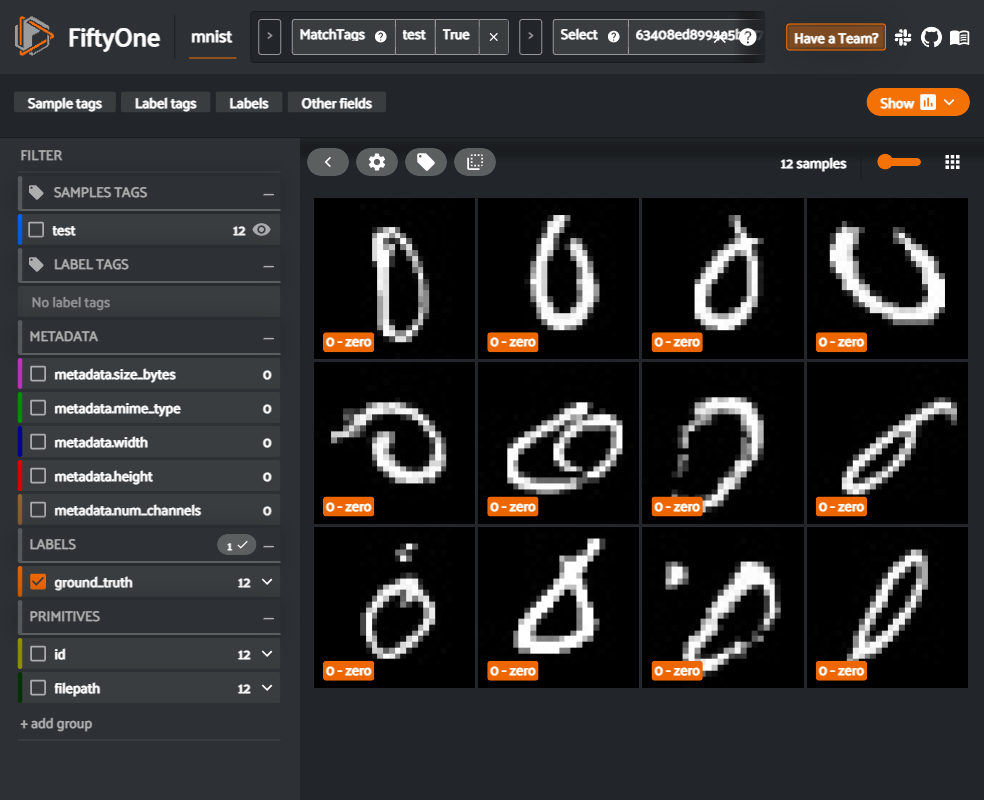

In [5]:
# Launch App instance
session = fo.launch_app(view=test_split)

In [6]:
# Plot embeddings colored by ground truth label
plot = results.visualize(labels="ground_truth.label")
plot.show(height=720)

# Attach plot to session
session.plots.attach(plot)

FigureWidget({
    'data': [{'customdata': array(['63408ed7994a5b8774469e8d', '63408ed7994a5b8774469ea0',
    …

In [7]:
session.freeze()  # screenshots App and plot for sharing

In [7]:
# Construct a ``num_samples x num_pixels`` array of images
embeddings = np.array([
    cv2.imread(f, cv2.IMREAD_UNCHANGED).ravel()
    for f in dataset.values("filepath")
])

# Compute 2D representation
results = fob.compute_visualization(
    dataset,
    embeddings=embeddings,
    num_dims=2,
    method="umap",
    brain_key="mnist",
    verbose=True,
    seed=51,
)

Generating visualization...
UMAP(random_state=51, verbose=True)
Thu Oct 13 13:05:12 2022 Construct fuzzy simplicial set
Thu Oct 13 13:05:12 2022 Finding Nearest Neighbors
Thu Oct 13 13:05:12 2022 Building RP forest with 18 trees
Thu Oct 13 13:05:15 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Oct 13 13:05:18 2022 Finished Nearest Neighbor Search
Thu Oct 13 13:05:19 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Oct 13 13:06:13 2022 Finished embedding


In [8]:
from fiftyone import ViewField as F

# Label `test` split samples by their ground truth label
# Mark all samples in `train` split as `unlabeled`
expr = F("$tags").contains("test").if_else(F("label"), "unlabeled")
labels = dataset.values("ground_truth", expr=expr)


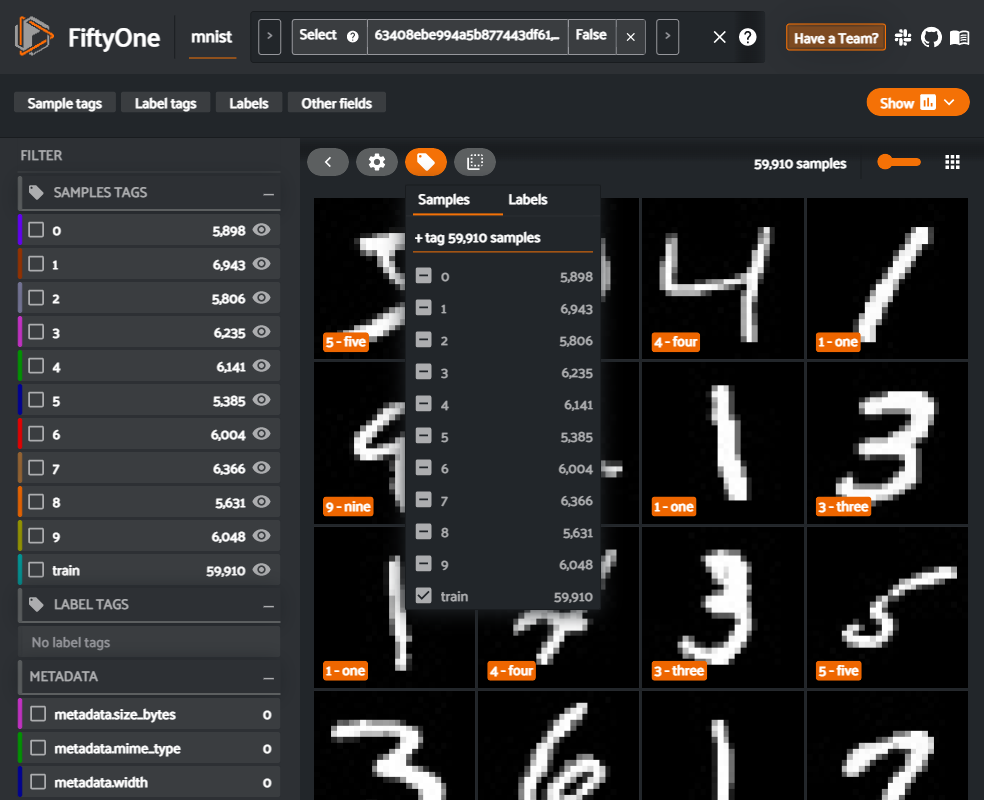

In [9]:
# Launch a new App instance
session = fo.launch_app(dataset)

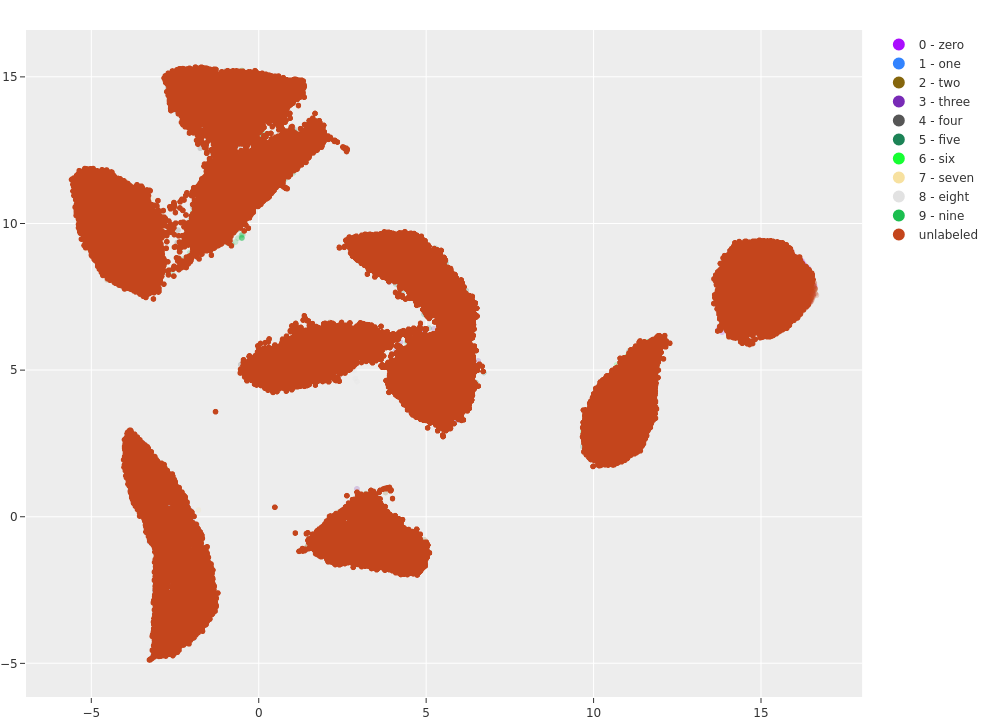

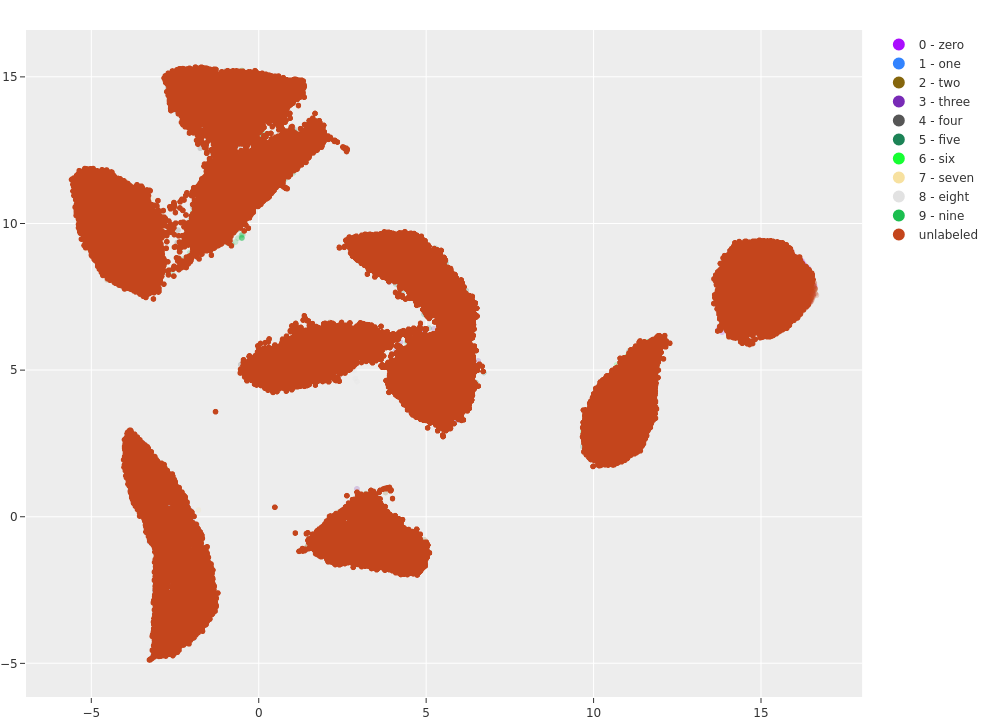

FigureWidget({
    'data': [{'customdata': array(['63408ed7994a5b8774469e8d', '63408ed7994a5b8774469ea0',
    …

In [10]:
# Visualize results
plot = results.visualize(labels=labels)
plot.show(height=720)

# Attach plot to session
session.plots.attach(plot)

In [11]:
# The train split that we pre-annotated
train_split = dataset.match_tags("train")

# Print state about labels that were added
print(train_split.count_sample_tags())

{'train': 60000, '9': 6048, '8': 5631, '1': 6943, '2': 5806, '5': 5385, '3': 6235, '7': 6366, '6': 6004, '4': 6141, '0': 5988}


In [12]:
# Add a new Classification field called `hypothesis` to store our guesses
with fo.ProgressBar() as pb:
    for sample in pb(train_split):
        labels = [t for t in sample.tags if t != "train"]
        if labels:
            sample["hypothesis"] = fo.Classification(label=labels[0])
            sample.save()

# Print stats about the labels we created
print(train_split.count_values("hypothesis.label"))

 100% |█████████████| 60000/60000 [2.9m elapsed, 0s remaining, 658.0 samples/s]      
{'4': 6141, '1': 6943, '9': 5626, '2': 5806, None: 44, '7': 6366, '3': 6235, '5': 5385, '6': 6004, '0': 5988, '8': 5462}


In [13]:
no_hypothesis = train_split.exists("hypothesis.label", False)
print(no_hypothesis)

Dataset:     mnist
Media type:  image
Num samples: 44
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    hypothesis:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
View stages:
    1. MatchTags(tags=['train'], bool=True)
    2. Exists(field='hypothesis.label', bool=False)


In [22]:
# Export `hypothesis` labels as a classification directory tree format
# `exists()` ensures that we only export samples with a hypothesis
train_split.exists("hypothesis.label").export(
    export_dir="Downloads/test",
    dataset_type=fo.types.ImageClassificationDirectoryTree,
    label_field="hypothesis",
)

 100% |█████████████| 59956/59956 [57.8s elapsed, 0s remaining, 1.3K samples/s]       


In [17]:
plot = fo.CategoricalHistogram(
    "hypothesis.label",
    order="frequency",
    log=True,
    init_view=dataset,
)

In [18]:
plot.show()

FigureWidget({
    'data': [{'hovertemplate': '<b>label: %{x}</b><br>count: %{y}<extra></extra>',
            …

In [24]:
session.freeze()  # screenshot app and plots for sharing

In [26]:
train_view = dataset.match_tags(tags=["train"])

# Compute embeddings
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")

train_embeddings = train_view.compute_embeddings(model)

/root/virtual/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/root/virtual/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.



 100% |█████████████| 60000/60000 [11.2m elapsed, 0s remaining, 78.7 samples/s]      


In [ ]:
#Qdrant allows storing not only vectors but also some corresponding attributes - each data point has a related vector and optionally a JSON payload attached to it. 
#Use this to pass in the ground truth label to make sure we can make our prediction later on.

ground_truth_labels, train_sample_ids = train_view.values(["ground_truth.label", "id"])
train_payload = [
    {"ground_truth": gt, "sample_id": sid} for gt, sid in zip(ground_truth_labels, train_sample_ids)
]

In [ ]:
import qdrant_client as qc
from qdrant_client.http.models import Distance

# Load the train embeddings into Qdrant
def create_and_upload_collection(embeddings, payload, collection_name="mnist"):
    client = qc.QdrantClient(host="localhost")
    client.recreate_collection(
        collection_name=collection_name,
        vector_size=embeddings.shape[1],
        distance=Distance.COSINE,
    )
    client.upload_collection(
        collection_name=collection_name,
        vectors=embeddings,
        payload=payload,
    )
    return client

In [ ]:
client = create_and_upload_collection(train_embeddings, train_payload)

In [ ]:
#Nearest Neighbor Classification

In [25]:
# Print your current config
print(fo.config)

# Print a specific config field
print(fo.config.default_ml_backend)

{
    "database_admin": true,
    "database_dir": "/root/.fiftyone/var/lib/mongo",
    "database_name": "fiftyone",
    "database_uri": null,
    "database_validation": true,
    "dataset_zoo_dir": "/root/fiftyone",
    "dataset_zoo_manifest_paths": null,
    "default_app_address": "localhost",
    "default_app_port": 5151,
    "default_batch_size": null,
    "default_dataset_dir": "/root/fiftyone",
    "default_image_ext": ".jpg",
    "default_ml_backend": "torch",
    "default_sequence_idx": "%06d",
    "default_video_ext": ".mp4",
    "desktop_app": false,
    "do_not_track": false,
    "logging_level": "INFO",
    "model_zoo_dir": "/root/fiftyone/__models__",
    "model_zoo_manifest_paths": null,
    "module_path": null,
    "requirement_error_level": 2,
    "show_progress_bars": true,
    "timezone": null
}
torch
